# setup 

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices() 

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6599796483148463287, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 11332668621
 locality {
   bus_id: 2
 }
 incarnation: 11345039182793113945
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:84:00.0"]

In [2]:
import numpy as np
import pandas as pd

from scipy import ndimage
from scipy import misc

import os, gc, sys, glob
from tqdm import tqdm

from sklearn import model_selection
from sklearn import metrics

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
DATA_DIR = os.path.join('/scratch', 'yns207', 'data_invasive')

path = DATA_DIR
test_path = os.path.join(path, 'test')
models_path = os.path.join(path, 'results')
train_path = os.path.join(path, 'train')
valid_path = os.path.join(path, 'valid')
print(path)

/scratch/yns207/data_invasive


```
%cd $DATA_DIR
!module load centos/7
!7za x '*.7z'
```

# defining funcs

In [20]:
def conv_block(filter_depth, filter_size, pool_size, activation, inputs):
    x = BatchNormalization()(inputs)
    x = Convolution2D(filter_depth, filter_size, activation=activation)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    return x

In [21]:
def dense_block(units, activation, drop_prob, inputs):
    x = BatchNormalization()(inputs)
    x = Dense(units, activation=activation)(x)
    x = Dropout(drop_prob)(x)
    return x

In [22]:
def output_block(units, activation, inputs):
    x = BatchNormalization()(inputs)
    x = Dense(units, activation=activation)(x)
    return x

In [25]:
def grab_optimizer(opt, lr):
    if opt == 'sgd':
        return optimizers.SGD(lr=lr, decay=1e-6, momentum=0.8, nesterov=True)
    elif opt == 'adam':
        return optimizers.Adam(lr=lr)
    elif opt == 'adagrad':
        return optimizers.Adagrad(lr=lr)
    elif opt == 'rmsprop':
        return optimizers.RMSprop(lr=lr)

In [26]:
def make_model(input_shape, optimizer):
    inputs = Input(shape=input_shape)
    m = conv_block(16, (3,3), (2,2),'relu', inputs=inputs)
    m = conv_block(32, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(64, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(128, (3,3), (2,2), 'relu', inputs=m)
    m = Flatten()(m)
    m = dense_block(2048, 'relu', 0.55, inputs=m)
    m = dense_block(512, 'relu', 0.65, inputs=m)
    outputs = dense_block(1, 'sigmoid', 0, inputs=m)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [27]:
def make_preds(model, test_data):
    # worth leaving a note:
    # prediction 1,2,3 from jun21 had misalgined the test names
    # also submission file 3 and 4 for jun21 are actually both rubmission 4 (accident)
    preds = model.predict(test_data).flatten()
    subm = test_set.copy()
    subm['invasive'] = preds
    return subm

In [10]:
train_set = pd.read_csv(os.path.join(path, 'train_labels.csv'))
test_set = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

In [11]:
train_set.head(2)

,name,invasive
0,1,0
1,2,0


In [12]:
#img_shape should eb tuple
#(H,W), height, width
def read_img(img_path, img_shape):
    img = misc.imread(img_path)
    img = misc.imresize(img, img_shape)
    return img

In [13]:
def read_imgs(img_height, img_width):
    train_img, test_img = [],[]
    for img_path in tqdm(train_set['name'].iloc[:]):
        train_img.append(read_img(os.path.join(path, 'train', str(img_path)+'.jpg'), (img_height, img_width)))

    for img_path in tqdm(test_set['name'].iloc[:]):
        test_img.append(read_img(os.path.join(path, 'test', str(img_path)+'.jpg'), (img_height, img_width)))

    train_img = np.array(train_img, np.float32)/255
    test_img = np.array(test_img, np.float32)/255
    train_label = np.array(train_set['invasive'].iloc[:])
    
    return train_img, test_img, train_label

In [14]:
train_img, test_img, train_label = read_imgs(128,128)

100%|██████████| 1531/1531 [00:47<00:00, 31.71it/s]


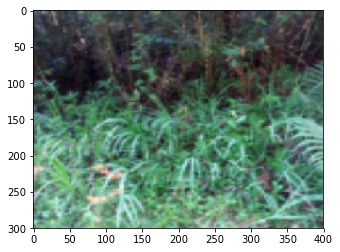

In [28]:
import matplotlib.pyplot as plt
plt.imshow(misc.imresize(train_img[0], (300,400)))
plt.show()

ok that seems to work, now lets try some k folds.

In [34]:
%cd $DATA_DIR
def train_model_k_folds(model, train_data, train_label, model_out,  model_init_weights, epochs, kfolds):
    kf = model_selection.KFold(n_splits=kfolds, shuffle=True)
    score_func = metrics.roc_auc_score

    i = 0
    for train_ixs, valid_ixs in kf.split(train_data):
        x_train = train_data[train_ixs]
        x_valid = train_data[valid_ixs]
        y_train = train_label[train_ixs]
        y_valid = train_label[valid_ixs]

        gen = ImageDataGenerator(
            rotation_range = 30,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            vertical_flip = True,
            fill_mode = 'nearest')
        
        #re-initialzie the weights of the model on each run
        model.load_weights(model_init_weights)
        
        model_checkpoint = ModelCheckpoint('/scratch/yns207/data_invasive/{}_{}.model'.format(model_out, str(i)), 
                                            monitor='val_loss', 
                                            save_best_only=True)
        early_stopping = EarlyStopping(monitor='val_loss', patience=17, verbose=1, mode='auto')

        hist = model.fit_generator(gen.flow(x_train, y_train, batch_size=64),
                            steps_per_epoch=(len(x_train)//64) + 1,
                            validation_data=(x_valid,y_valid),
                            validation_steps=(len(x_valid)//64)+1,
                            epochs=epochs,
                            verbose=1,
                            callbacks=[early_stopping, model_checkpoint])
        
        model.load_weights('/scratch/yns207/data_invasive/{}_{}.model'.format(model_out, str(i)))
        
        eval_tr = model.evaluate(x_train, y_train)
        eval_va = model.evaluate(x_valid, y_valid)
        
        tr_score = score_func(y_train, model.predict(x_train)[:, 0])
        va_score = score_func(y_valid, model.predict(x_valid)[:, 0])
        
        print('\n')
        print('kfold: {}'.format(str(i)))
        print('best model train acc: {}, loss: {}'.format(eval_tr[1], eval_tr[0]))
        print('best model valid acc: {}, loss: {}'.format(eval_va[1], eval_va[0]))
        print('best model train aroc score: {}, valid aroc score: {}'.format(tr_score, va_score))
        print('\n')
        i += 1

/scratch/yns207/data_invasive


In [35]:
# make a model
model = make_model((128,128,3), grab_optimizer('sgd', 0.0025))
# save initial weights for use on each kfolds run
model.save_weights('model_jun22_kfold_base.model')
# run kfolds 10x
train_model_k_folds(model, train_img, train_label, 'model_jun22_kfold', 'model_jun22_kfold_base.model',100, 10)

Epoch 1/100
33/33 [==============================] - 5s - loss: 0.7301 - acc: 0.6202 - val_loss: 0.8914 - val_acc: 0.3696
Epoch 2/100
33/33 [==============================] - 5s - loss: 0.6161 - acc: 0.7031 - val_loss: 1.3312 - val_acc: 0.3696
Epoch 3/100
33/33 [==============================] - 5s - loss: 0.5686 - acc: 0.7359 - val_loss: 1.6788 - val_acc: 0.3696
Epoch 4/100
33/33 [==============================] - 5s - loss: 0.5143 - acc: 0.7632 - val_loss: 1.9961 - val_acc: 0.3696
Epoch 5/100
33/33 [==============================] - 5s - loss: 0.5078 - acc: 0.7632 - val_loss: 1.9660 - val_acc: 0.3696
Epoch 6/100
33/33 [==============================] - 5s - loss: 0.4866 - acc: 0.7703 - val_loss: 2.3516 - val_acc: 0.3696
Epoch 7/100
33/33 [==============================] - 5s - loss: 0.4366 - acc: 0.7977 - val_loss: 2.1920 - val_acc: 0.3696
Epoch 8/100
33/33 [==============================] - 5s - loss: 0.4125 - acc: 0.8048 - val_loss: 2.1711 - val_acc: 0.3696
Epoch 9/100
33/33 [=====

33/33 [==============================] - 5s - loss: 0.2181 - acc: 0.9099 - val_loss: 0.1327 - val_acc: 0.9565
Epoch 00066: early stopping
224/230 [============================>.] - ETA: 0skfold: 0
best model train acc: 0.9365617433991328, loss: 0.1591744862514893
best model valid acc: 0.9565217401670373, loss: 0.12872577076372893
best model train aroc score: 0.9848159808880376, valid aroc score: 0.9891277890466531


Epoch 1/100
33/33 [==============================] - 5s - loss: 0.7445 - acc: 0.6045 - val_loss: 0.9468 - val_acc: 0.3652
Epoch 2/100
33/33 [==============================] - 5s - loss: 0.6013 - acc: 0.7089 - val_loss: 1.2508 - val_acc: 0.3652
Epoch 3/100
33/33 [==============================] - 5s - loss: 0.5622 - acc: 0.7255 - val_loss: 1.6426 - val_acc: 0.3652
Epoch 4/100
33/33 [==============================] - 5s - loss: 0.4955 - acc: 0.7702 - val_loss: 2.0222 - val_acc: 0.3652
Epoch 5/100
33/33 [==============================] - 5s - loss: 0.4739 - acc: 0.7792 - val_l

33/33 [==============================] - 5s - loss: 0.2169 - acc: 0.9161 - val_loss: 0.1592 - val_acc: 0.9435
Epoch 65/100
33/33 [==============================] - 5s - loss: 0.1887 - acc: 0.9278 - val_loss: 0.1337 - val_acc: 0.9609
Epoch 66/100
33/33 [==============================] - 5s - loss: 0.1920 - acc: 0.9250 - val_loss: 0.1429 - val_acc: 0.9522
Epoch 67/100
33/33 [==============================] - 5s - loss: 0.1955 - acc: 0.9201 - val_loss: 0.1317 - val_acc: 0.9522
Epoch 68/100
33/33 [==============================] - 5s - loss: 0.1928 - acc: 0.9275 - val_loss: 0.1205 - val_acc: 0.9609
Epoch 69/100
33/33 [==============================] - 5s - loss: 0.1830 - acc: 0.9338 - val_loss: 0.1266 - val_acc: 0.9652
Epoch 70/100
33/33 [==============================] - 5s - loss: 0.1804 - acc: 0.9340 - val_loss: 0.1183 - val_acc: 0.9609
Epoch 71/100
33/33 [==============================] - 5s - loss: 0.1816 - acc: 0.9356 - val_loss: 0.1104 - val_acc: 0.9609
Epoch 72/100
33/33 [=========

33/33 [==============================] - 5s - loss: 0.2612 - acc: 0.8935 - val_loss: 0.2007 - val_acc: 0.9304
Epoch 29/100
33/33 [==============================] - 5s - loss: 0.2555 - acc: 0.8973 - val_loss: 0.2010 - val_acc: 0.9217
Epoch 30/100
33/33 [==============================] - 5s - loss: 0.2618 - acc: 0.9008 - val_loss: 0.1750 - val_acc: 0.9391
Epoch 31/100
33/33 [==============================] - 5s - loss: 0.2602 - acc: 0.8946 - val_loss: 0.2021 - val_acc: 0.9174
Epoch 32/100
33/33 [==============================] - 5s - loss: 0.2596 - acc: 0.9002 - val_loss: 0.1757 - val_acc: 0.9348
Epoch 33/100
33/33 [==============================] - 5s - loss: 0.2524 - acc: 0.9095 - val_loss: 0.1940 - val_acc: 0.9304
Epoch 34/100
33/33 [==============================] - 5s - loss: 0.2372 - acc: 0.8987 - val_loss: 0.1962 - val_acc: 0.9174
Epoch 35/100
33/33 [==============================] - 5s - loss: 0.2380 - acc: 0.9057 - val_loss: 0.1965 - val_acc: 0.9348
Epoch 36/100
33/33 [=========

33/33 [==============================] - 5s - loss: 0.1792 - acc: 0.9346 - val_loss: 0.0878 - val_acc: 0.9696
Epoch 95/100
33/33 [==============================] - 5s - loss: 0.1786 - acc: 0.9333 - val_loss: 0.1036 - val_acc: 0.9652
Epoch 96/100
33/33 [==============================] - 5s - loss: 0.1714 - acc: 0.9341 - val_loss: 0.0897 - val_acc: 0.9652
Epoch 97/100
33/33 [==============================] - 5s - loss: 0.1798 - acc: 0.9307 - val_loss: 0.0957 - val_acc: 0.9652
Epoch 98/100
33/33 [==============================] - 5s - loss: 0.1701 - acc: 0.9419 - val_loss: 0.0917 - val_acc: 0.9652
Epoch 99/100
33/33 [==============================] - 5s - loss: 0.1566 - acc: 0.9389 - val_loss: 0.1040 - val_acc: 0.9652
Epoch 100/100
224/230 [============================>.] - ETA: 0s0s - ETAkfold: 2
best model train acc: 0.9554479419463483, loss: 0.11642121140085179
best model valid acc: 0.9739130434782609, loss: 0.08351172267094903
best model train aroc score: 0.9917397519917759, valid aro

33/33 [==============================] - 5s - loss: 0.1945 - acc: 0.9300 - val_loss: 0.1429 - val_acc: 0.9435
Epoch 59/100
33/33 [==============================] - 5s - loss: 0.1915 - acc: 0.9305 - val_loss: 0.1367 - val_acc: 0.9522
Epoch 60/100
33/33 [==============================] - 5s - loss: 0.1880 - acc: 0.9248 - val_loss: 0.1588 - val_acc: 0.9435
Epoch 61/100
33/33 [==============================] - 5s - loss: 0.1925 - acc: 0.9250 - val_loss: 0.1318 - val_acc: 0.9522
Epoch 62/100
33/33 [==============================] - 5s - loss: 0.1856 - acc: 0.9324 - val_loss: 0.1789 - val_acc: 0.9478
Epoch 63/100
33/33 [==============================] - 5s - loss: 0.1915 - acc: 0.9291 - val_loss: 0.1802 - val_acc: 0.9174
Epoch 64/100
33/33 [==============================] - 5s - loss: 0.1998 - acc: 0.9212 - val_loss: 0.1312 - val_acc: 0.9522
Epoch 65/100
33/33 [==============================] - 5s - loss: 0.2049 - acc: 0.9166 - val_loss: 0.1348 - val_acc: 0.9478
Epoch 66/100
33/33 [=========

33/33 [==============================] - 5s - loss: 0.2238 - acc: 0.9095 - val_loss: 0.3411 - val_acc: 0.8565
Epoch 41/100
33/33 [==============================] - 5s - loss: 0.2406 - acc: 0.9049 - val_loss: 0.1750 - val_acc: 0.9304
Epoch 42/100
33/33 [==============================] - 5s - loss: 0.2223 - acc: 0.9169 - val_loss: 0.1772 - val_acc: 0.9478
Epoch 43/100
33/33 [==============================] - 5s - loss: 0.2066 - acc: 0.9237 - val_loss: 0.1883 - val_acc: 0.9174
Epoch 44/100
33/33 [==============================] - 5s - loss: 0.2098 - acc: 0.9187 - val_loss: 0.1703 - val_acc: 0.9435
Epoch 45/100
33/33 [==============================] - 5s - loss: 0.2301 - acc: 0.9099 - val_loss: 0.1942 - val_acc: 0.9217
Epoch 46/100
33/33 [==============================] - 5s - loss: 0.2256 - acc: 0.9171 - val_loss: 0.2587 - val_acc: 0.8826
Epoch 47/100
33/33 [==============================] - 5s - loss: 0.2211 - acc: 0.9166 - val_loss: 0.1936 - val_acc: 0.9130
Epoch 48/100
33/33 [=========

33/33 [==============================] - 5s - loss: 0.2175 - acc: 0.9157 - val_loss: 0.1748 - val_acc: 0.9127
Epoch 43/100
33/33 [==============================] - 5s - loss: 0.2247 - acc: 0.9161 - val_loss: 0.1834 - val_acc: 0.9345
Epoch 44/100
33/33 [==============================] - 5s - loss: 0.2115 - acc: 0.9214 - val_loss: 0.1735 - val_acc: 0.9345
Epoch 45/100
33/33 [==============================] - 5s - loss: 0.2099 - acc: 0.9136 - val_loss: 0.1786 - val_acc: 0.9258
Epoch 46/100
33/33 [==============================] - 5s - loss: 0.2129 - acc: 0.9145 - val_loss: 0.1868 - val_acc: 0.9170
Epoch 47/100
33/33 [==============================] - 5s - loss: 0.2240 - acc: 0.9157 - val_loss: 0.2095 - val_acc: 0.9170
Epoch 48/100
33/33 [==============================] - 5s - loss: 0.2061 - acc: 0.9242 - val_loss: 0.1753 - val_acc: 0.9345
Epoch 49/100
33/33 [==============================] - 5s - loss: 0.2016 - acc: 0.9176 - val_loss: 0.1566 - val_acc: 0.9258
Epoch 50/100
33/33 [=========

33/33 [==============================] - 5s - loss: 0.4605 - acc: 0.7814 - val_loss: 2.4812 - val_acc: 0.3581
Epoch 7/100
33/33 [==============================] - 5s - loss: 0.4372 - acc: 0.8105 - val_loss: 2.3835 - val_acc: 0.3581
Epoch 8/100
33/33 [==============================] - 5s - loss: 0.4185 - acc: 0.8143 - val_loss: 2.0658 - val_acc: 0.3581
Epoch 9/100
33/33 [==============================] - 5s - loss: 0.3941 - acc: 0.8276 - val_loss: 1.8340 - val_acc: 0.3712
Epoch 10/100
33/33 [==============================] - 5s - loss: 0.3746 - acc: 0.8368 - val_loss: 1.5452 - val_acc: 0.4323
Epoch 11/100
33/33 [==============================] - 5s - loss: 0.3528 - acc: 0.8508 - val_loss: 0.9409 - val_acc: 0.6638
Epoch 12/100
33/33 [==============================] - 5s - loss: 0.3424 - acc: 0.8468 - val_loss: 0.7279 - val_acc: 0.7336
Epoch 13/100
33/33 [==============================] - 5s - loss: 0.3321 - acc: 0.8638 - val_loss: 0.6523 - val_acc: 0.7598
Epoch 14/100
33/33 [============

33/33 [==============================] - 5s - loss: 0.1641 - acc: 0.9346 - val_loss: 0.1886 - val_acc: 0.9127
Epoch 73/100
33/33 [==============================] - 5s - loss: 0.1920 - acc: 0.9301 - val_loss: 0.1737 - val_acc: 0.9214
Epoch 74/100
33/33 [==============================] - 5s - loss: 0.1960 - acc: 0.9247 - val_loss: 0.1987 - val_acc: 0.9301
Epoch 75/100
33/33 [==============================] - 5s - loss: 0.1748 - acc: 0.9327 - val_loss: 0.1789 - val_acc: 0.9345
Epoch 76/100
33/33 [==============================] - 5s - loss: 0.1789 - acc: 0.9308 - val_loss: 0.2014 - val_acc: 0.9127
Epoch 77/100
33/33 [==============================] - 5s - loss: 0.1668 - acc: 0.9382 - val_loss: 0.1984 - val_acc: 0.9083
Epoch 78/100
33/33 [==============================] - 5s - loss: 0.1828 - acc: 0.9325 - val_loss: 0.1727 - val_acc: 0.9170
Epoch 79/100
33/33 [==============================] - 5s - loss: 0.1656 - acc: 0.9330 - val_loss: 0.1948 - val_acc: 0.9083
Epoch 80/100
33/33 [=========

33/33 [==============================] - 5s - loss: 0.2323 - acc: 0.8998 - val_loss: 0.2152 - val_acc: 0.9170
Epoch 37/100
33/33 [==============================] - 5s - loss: 0.2140 - acc: 0.9171 - val_loss: 0.2318 - val_acc: 0.9214
Epoch 38/100
33/33 [==============================] - 5s - loss: 0.2179 - acc: 0.9183 - val_loss: 0.2498 - val_acc: 0.9170
Epoch 39/100
33/33 [==============================] - 5s - loss: 0.2318 - acc: 0.9102 - val_loss: 0.2181 - val_acc: 0.9170
Epoch 40/100
33/33 [==============================] - 5s - loss: 0.2183 - acc: 0.9159 - val_loss: 0.2518 - val_acc: 0.9214
Epoch 41/100
33/33 [==============================] - 5s - loss: 0.2278 - acc: 0.9126 - val_loss: 0.2276 - val_acc: 0.9214
Epoch 42/100
33/33 [==============================] - 5s - loss: 0.2040 - acc: 0.9235 - val_loss: 0.2130 - val_acc: 0.9214
Epoch 43/100
33/33 [==============================] - 5s - loss: 0.2183 - acc: 0.9214 - val_loss: 0.2354 - val_acc: 0.9258
Epoch 44/100
33/33 [=========

33/33 [==============================] - 5s - loss: 0.4894 - acc: 0.7748 - val_loss: 2.4565 - val_acc: 0.3886
Epoch 6/100
33/33 [==============================] - 5s - loss: 0.4542 - acc: 0.7918 - val_loss: 2.3941 - val_acc: 0.3886
Epoch 7/100
33/33 [==============================] - 5s - loss: 0.4278 - acc: 0.8081 - val_loss: 2.4960 - val_acc: 0.3886
Epoch 8/100
33/33 [==============================] - 5s - loss: 0.3985 - acc: 0.8245 - val_loss: 2.1822 - val_acc: 0.3886
Epoch 9/100
33/33 [==============================] - 5s - loss: 0.4078 - acc: 0.8188 - val_loss: 1.9871 - val_acc: 0.3886
Epoch 10/100
33/33 [==============================] - 5s - loss: 0.3688 - acc: 0.8392 - val_loss: 1.5571 - val_acc: 0.4454
Epoch 11/100
33/33 [==============================] - 5s - loss: 0.3485 - acc: 0.8449 - val_loss: 1.4620 - val_acc: 0.5153
Epoch 12/100
33/33 [==============================] - 5s - loss: 0.3297 - acc: 0.8543 - val_loss: 1.0419 - val_acc: 0.5808
Epoch 13/100
33/33 [=============

33/33 [==============================] - 5s - loss: 0.1850 - acc: 0.9275 - val_loss: 0.1663 - val_acc: 0.9389
Epoch 72/100
33/33 [==============================] - 5s - loss: 0.1721 - acc: 0.9360 - val_loss: 0.2557 - val_acc: 0.9214
Epoch 73/100
33/33 [==============================] - 5s - loss: 0.1733 - acc: 0.9283 - val_loss: 0.1869 - val_acc: 0.9258
Epoch 74/100
33/33 [==============================] - 5s - loss: 0.1746 - acc: 0.9358 - val_loss: 0.1845 - val_acc: 0.9170
Epoch 75/100
33/33 [==============================] - 5s - loss: 0.1827 - acc: 0.9297 - val_loss: 0.1873 - val_acc: 0.9214
Epoch 76/100
33/33 [==============================] - 5s - loss: 0.1697 - acc: 0.9356 - val_loss: 0.2127 - val_acc: 0.9301
Epoch 77/100
33/33 [==============================] - 5s - loss: 0.1775 - acc: 0.9389 - val_loss: 0.2242 - val_acc: 0.9170
Epoch 78/100
33/33 [==============================] - 5s - loss: 0.1828 - acc: 0.9327 - val_loss: 0.1775 - val_acc: 0.9301
Epoch 79/100
33/33 [=========

33/33 [==============================] - 5s - loss: 0.2172 - acc: 0.9176 - val_loss: 0.1787 - val_acc: 0.9258
Epoch 47/100
33/33 [==============================] - 5s - loss: 0.2248 - acc: 0.9166 - val_loss: 0.1450 - val_acc: 0.9301
Epoch 48/100
33/33 [==============================] - 5s - loss: 0.1971 - acc: 0.9242 - val_loss: 0.1820 - val_acc: 0.9214
Epoch 49/100
33/33 [==============================] - 5s - loss: 0.2116 - acc: 0.9173 - val_loss: 0.1634 - val_acc: 0.9258
Epoch 50/100
33/33 [==============================] - 5s - loss: 0.2004 - acc: 0.9197 - val_loss: 0.2352 - val_acc: 0.9039
Epoch 51/100
33/33 [==============================] - 5s - loss: 0.2144 - acc: 0.9169 - val_loss: 0.1507 - val_acc: 0.9389
Epoch 52/100
33/33 [==============================] - 5s - loss: 0.2104 - acc: 0.9221 - val_loss: 0.1520 - val_acc: 0.9389
Epoch 53/100
33/33 [==============================] - 5s - loss: 0.2201 - acc: 0.9190 - val_loss: 0.1426 - val_acc: 0.9345
Epoch 54/100
33/33 [=========

In [38]:
# two paths 1 just pick all the models with a loss below a certain amt
# or
# 2 now ensemble all the models and have them vote (avg) but ADJUST by their validation/ training loss or that model, or weight them by how good their aroc score is.
# or 
# we just pick the model that did the best on its validation set
# or
# should we be adjusting based on ROC score on the train+validation sets?

# ok lets just try the #1, lets just pick the 3 best models ensemble them. the reason i pick 3 and dont just use all the models is that
# some of the models were stopped early, and thus are pretty shit. (should prob just let them all run), this is fitting a little but 
# its not too bad

# model from kfold 2 - 0.995976
# model from kfold 1 - 0.994129
# model from kfold 9 - 0.994577
subm = test_set.iloc[:]
subm = subm.drop('invasive',1)

%cd $DATA_DIR
models = [1,2,9]
model = make_model((128,128,3), grab_optimizer('sgd', 0.0025))

for f in models:
    model.load_weights('model_jun22_kfold_{}.model'.format(str(f)))
    subm[str(f)] = make_preds(model, test_img)['invasive']
subm.head()

/scratch/yns207/data_invasive


,name,1,2,9
0,1,0.999356,0.999651,0.999726
1,2,0.012992,0.012299,0.074847
2,3,0.055714,0.036986,0.125450
3,4,0.016070,0.037797,0.080805
4,5,0.887863,0.794534,0.863607


In [46]:
subm['invasive'] = subm[[str(f) for f in models]].mean(axis=1)
subm = subm.drop([str(f) for f in models], 1)
subm.head()

,name,invasive
0,1,0.999578
1,2,0.033380
2,3,0.072717
3,4,0.044891
4,5,0.848668


In [48]:
subm.to_csv(os.path.join(DATA_DIR, 'results', 'subm_jun_22_17_2.gz'), index=False, compression='gzip')

In [ ]:
# %cd $DATA_DIR
# model = make_model((128,128,3), grab_optimizer('sgd', 0.005))
# model.load_weights('model_jun21_kfold_6.model')
# subm = make_preds(model, test_img)
# subm.to_csv(os.path.join(DATA_DIR, 'results', 'subm_jun_22_17_2.gz'), index=False, compression='gzip')